In [139]:
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import preamble
from src.constants import COLOR_MAPS, PATH_VOCAB_EMBEDDED, EMBEDDING_MODEL, PATH_MIGRATION_SPEECHES_EMBEDDED
from src.dim_reduction import display_axis_semantics, closest_words_for_pc, get_extreme_examples, get_aggregated_embeddings_for_each_year

In [140]:
df = pd.read_parquet(PATH_MIGRATION_SPEECHES_EMBEDDED)
print(f"#Samples: {len(df)}")

#Samples: 9705


In [141]:
vocab_df = pd.read_parquet(PATH_VOCAB_EMBEDDED)

# Partial least squares regression

Identify component in our embeddings which explain our target variable (party affiliation)

In [142]:
aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_MODEL, 'block')

In [143]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split


train, test = train_test_split(df, test_size=.1)


lb = LabelEncoder()
y_train = lb.fit_transform(train["block"])
y_test = lb.transform(test["block"])

X_test = np.stack(test[EMBEDDING_MODEL])
X_train = np.stack(train[EMBEDDING_MODEL])
print(f"#Classes {len(lb.classes_)}")

y = np.eye(len(lb.classes_))[y_train]  # create one-hot encodding to use PLS for classification PLS-DA


pls = PLSRegression(n_components=2)
pls.fit(X_train, y)

reduced = pls.transform(np.stack(df[EMBEDDING_MODEL]))

print(f"PLS r-squared {pls.score(X_test, np.eye(len(lb.classes_))[y_test]):.3f}")


#Classes 6
PLS r-squared 0.111


In [144]:
df['reduced_0'] = reduced[:, 0] 
df['reduced_1'] = reduced[:, 1] 

In [145]:
for year in test['year'].unique():
    mask = year == test['year'] 
    X_year = np.stack(test[mask][EMBEDDING_MODEL])
    y_year = lb.transform(test[mask]['block'])
    y_pred =  pls.predict(X_year).argmax(axis=1)
    print(year, len(y_year))
    print(f"PLS Accuracy {(y_pred == y_year).mean()}")


2016 370
PLS Accuracy 0.4972972972972973
2017 59
PLS Accuracy 0.4915254237288136
2015 260
PLS Accuracy 0.46153846153846156
2018 52
PLS Accuracy 0.4230769230769231
2023 49
PLS Accuracy 0.4897959183673469
2021 47
PLS Accuracy 0.3617021276595745
2019 41
PLS Accuracy 0.5365853658536586
2020 25
PLS Accuracy 0.56
2022 35
PLS Accuracy 0.3142857142857143
2014 26
PLS Accuracy 0.3076923076923077
2024 7
PLS Accuracy 0.5714285714285714


## Plotting Results

In [162]:
def plot_aggregated_yearly_data(aggregated: pd.DataFrame, reduced_embeddings: np.array, target_var: str, color_map: dict, ax):
  ax.set_title("Two Dimensional Projection of Political Groups")

  grt_y = np.abs(reduced_embeddings[:, 1]).max() * 1.1
  grt_x = np.abs(reduced_embeddings[:, 0]).max() * 1.1

  ax.set_xlim(-grt_x, grt_x)
  ax.set_ylim(-grt_y, grt_y)

  scale = grt_y * 2

  unique_years = list(aggregated['year'].unique() )
  years_to_display = unique_years[::-2]

  ax.set_xlabel("First Axis")
  ax.set_ylabel("Second Axis")

  for party in aggregated[target_var].unique():
      party_mask = aggregated[target_var] == party
      years = aggregated[party_mask]['year']
      party_embeddings = reduced_embeddings[party_mask]
      
      ax.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=color_map[party], label=party)
      for i, year in enumerate(years):
        if year in years_to_display:
          ax.text(party_embeddings[i,0] - scale * 0.025, party_embeddings[i,1]+ scale * 0.03, f"{year}",
                    fontsize=8, bbox=dict(boxstyle="round", color=color_map[party], alpha=0.7), 
                    color='white',
                    )

  ax.axhline(0, linestyle="--")
  ax.axvline(0, linestyle="--")
  ax.grid()
  ax.legend(loc="upper left")
  return ax

In [ ]:
import seaborn as sns
def plot_pca_axis_development(df: pd.DataFrame, axis: int, aggregated: pd.DataFrame,  target_var: str, reduced_embeddings: np.array, 
                              axis_labels: tuple[list[str]], color_map: dict, ax: plt.Axes,
                              top_k: int = 3):

    ax.set_title(f"Development of parties over the years accross reduced-axis {axis + 1}")


    sns.lineplot(data=df, x='year', y=f"reduced_{axis}", marker='o', hue=target_var, palette=color_map, ax=ax, legend=False)
    ax.set_ylabel("")

    
    max_y_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))

    ax.set_ylim((-max_y_lim, max_y_lim))  
    ax.axhline(0, linestyle="--")

    ax_label_neg = ', '.join(map(lambda x: x[0], axis_labels[0][:top_k]))
    ax_label_pos = ', '.join(map(lambda x: x[0], axis_labels[1][:top_k]))

    props = dict(boxstyle='round', facecolor="grey", alpha=0.5)

    # label for negative axis: 
    ax.text(2014, -0.8 * max_y_lim , f"{ax_label_neg}", horizontalalignment="left", bbox=props)
    # label for positive axis: 
    ax.text(2014, 0.8 * max_y_lim, f"{ax_label_pos}", horizontalalignment="left", bbox=props)
    ax.grid()
    # ax.legend(loc="lower left")


In [185]:
df['translatedText'].str.contains("border").sum() / len(df) * 100

np.float64(42.26687274600721)

In [186]:
df[df['translatedText'].str.contains("border")]['year'].value_counts()

year
2016    1263
2015     899
2021     338
2023     297
2018     276
2017     271
2022     252
2019     183
2020     163
2014     103
2024      57
Name: count, dtype: int64

In [187]:
df[~df['translatedText'].str.contains("border")]['year'].value_counts()

year
2016    2277
2015    1590
2017     384
2018     308
2023     267
2019     192
2014     169
2022     139
2021     134
2020      96
2024      47
Name: count, dtype: int64

In [188]:
def display_results(df: pd.DataFrame, model, axis: tuple[int], aggregated: pd.DataFrame, vocab_df: pd.DataFrame,
                     reduced_embeddings: np.stack, target_var: str, color_map: dict) -> None:
    
    fig = plt.figure(layout="constrained")

    gs0 = fig.add_gridspec(1, 2)

    gs1 = gs0[1].subgridspec(2, 1)

    ax1 = fig.add_subplot(gs0[0])
    ax2 = fig.add_subplot(gs1[0])
    ax3 = fig.add_subplot(gs1[1], sharex=ax2)

    axis_labels_0 = closest_words_for_pc(axis[0], model, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
    axis_labels_1  = closest_words_for_pc(axis[1], model, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

    display_axis_semantics([(axis_labels_0), 
                            (axis_labels_1)])

    plot_aggregated_yearly_data(aggregated, reduced_embeddings, target_var, color_map, ax1)
    plot_pca_axis_development(df, 0, aggregated, target_var, reduced_embeddings, axis_labels_0, color_map, ax2)
    plot_pca_axis_development(df, 1, aggregated, target_var, reduced_embeddings, axis_labels_1, color_map, ax3)


In [189]:
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"


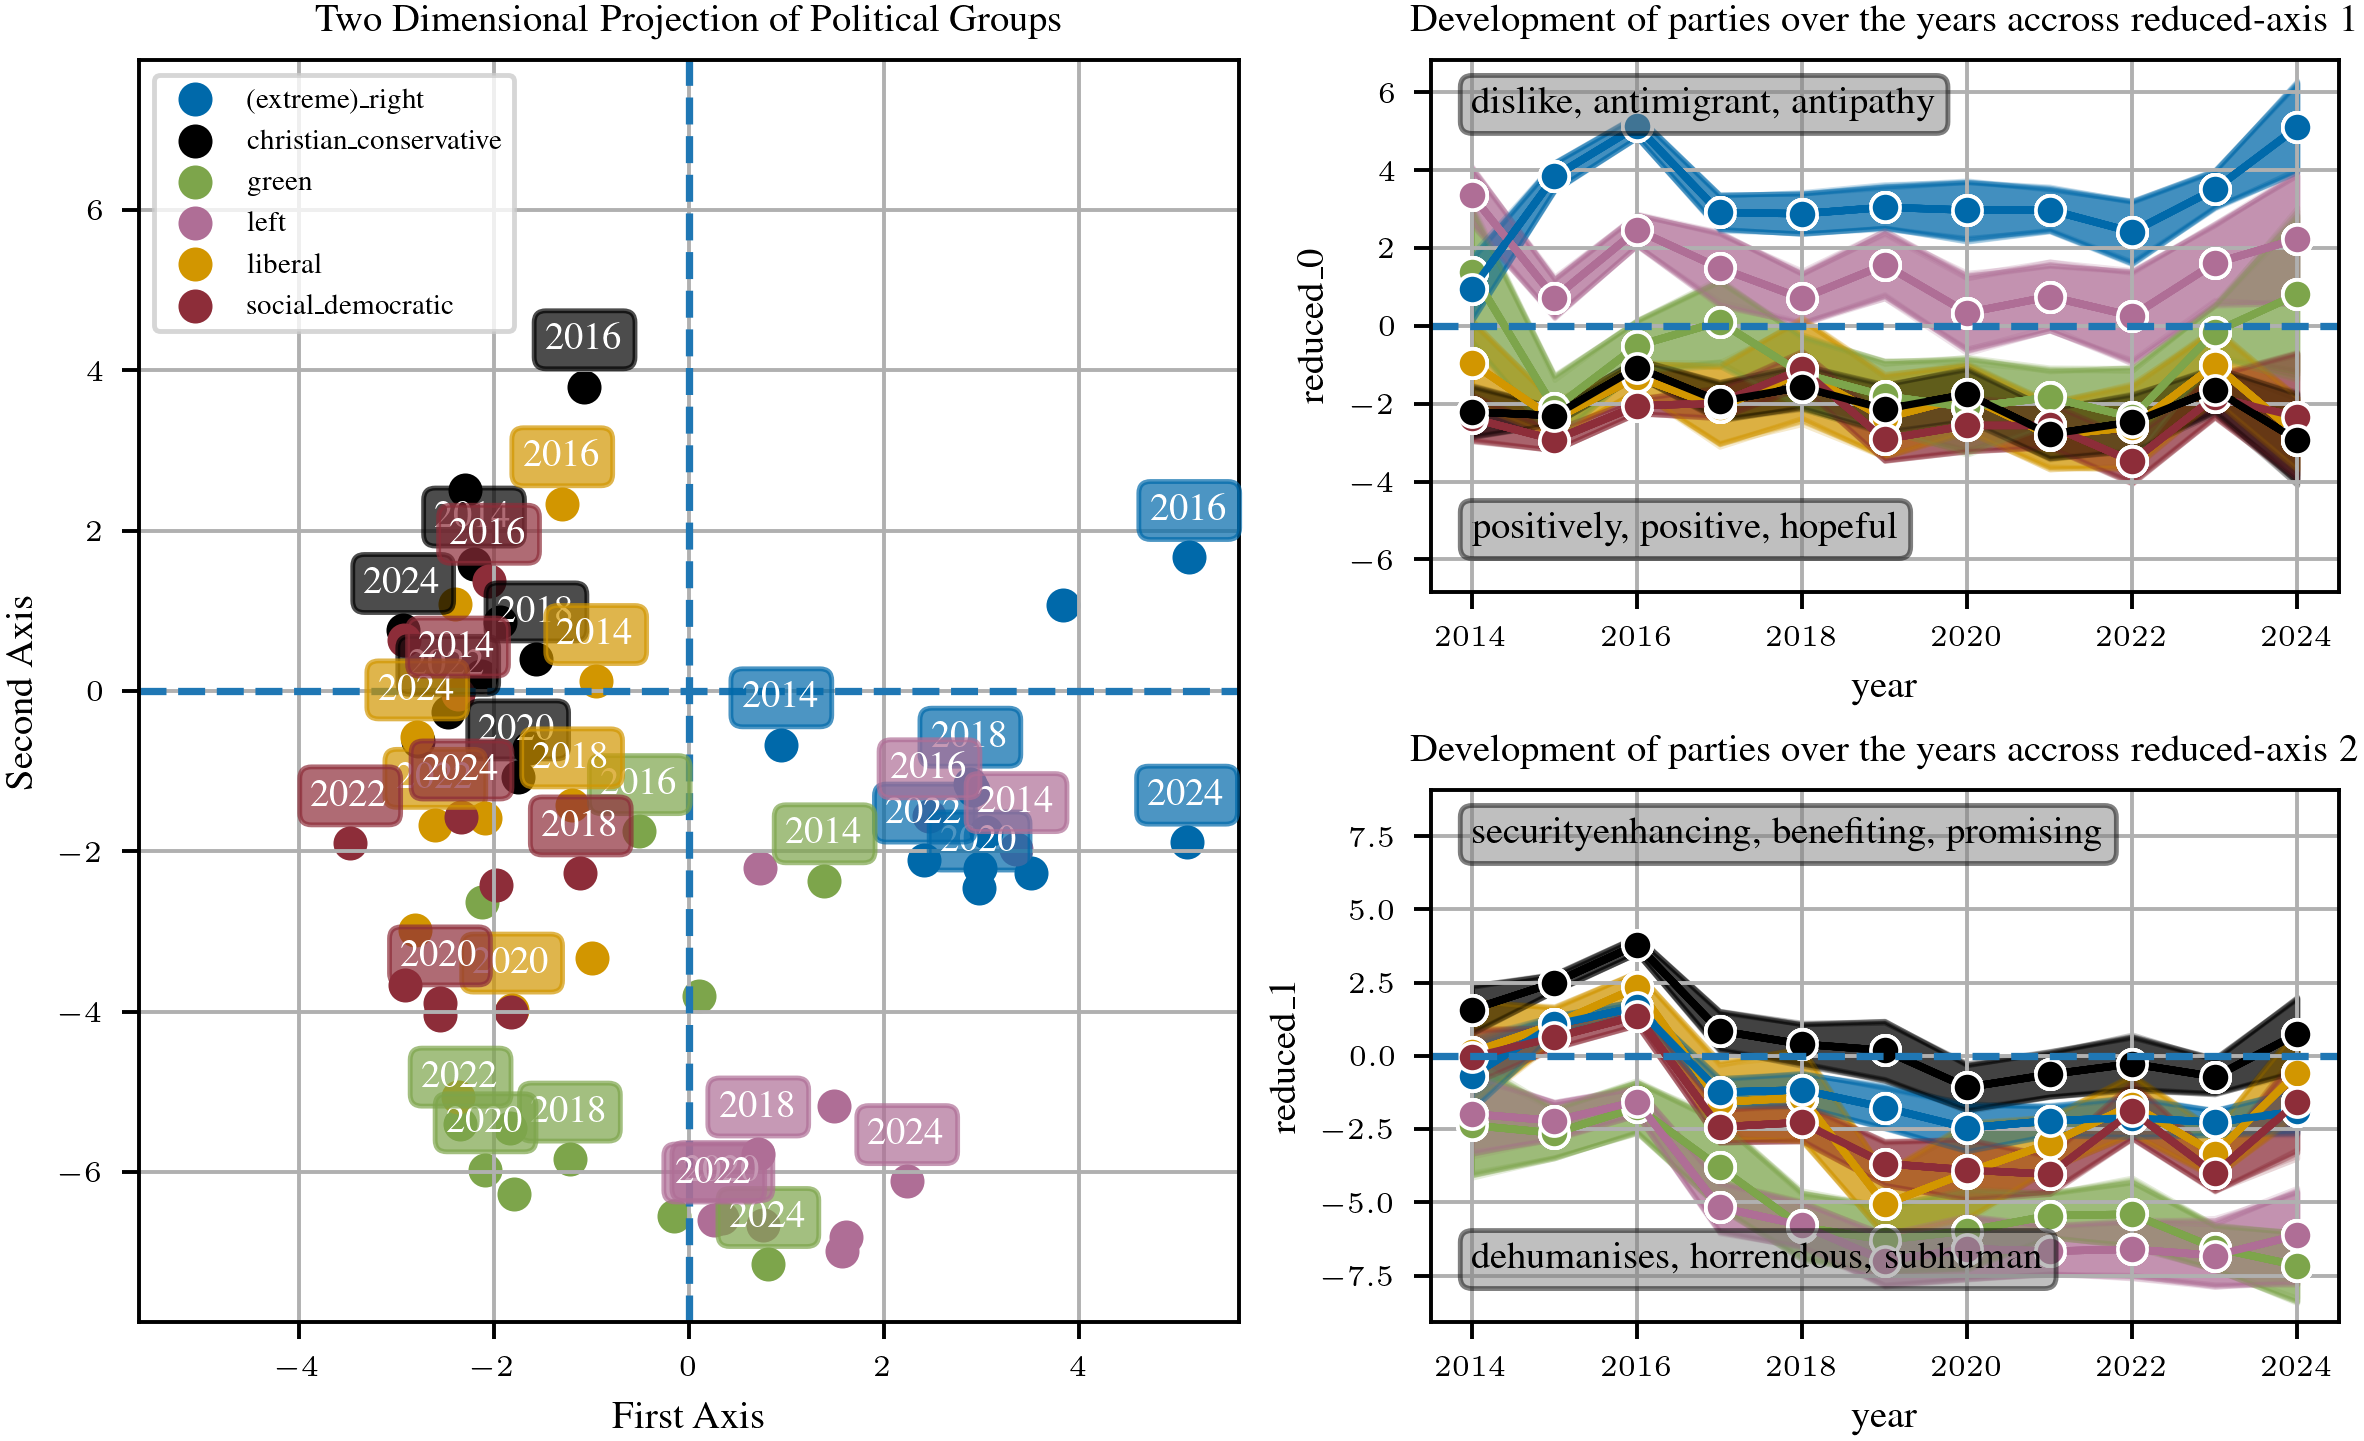

In [190]:
from tueplots import bundles

params = bundles.icml2024(nrows=1,ncols=1, column="full") # if you need multiple columns / rows, change in your script
# params.update({"figure.dpi": 350})
plt.rcParams.update(params)

display_results(df, pls, [0, 1], aggregated, vocab_df, 
                pls.transform(np.stack(aggregated[EMBEDDING_MODEL])), "block", COLOR_MAPS['block'])

In [10]:
reduced = pls.transform(np.stack(df[EMBEDDING_MODEL]))
normalized = reduced 
#/ np.linalg.vector_norm(reduced, ord=2, axis=1, keepdims=True)

In [11]:
def get_top_k_extreme_examples(df: pd.DataFrame, embeddings: np.array, top_k=10):
    sorted_0 = embeddings[:, 0].argsort()
    sorted_1 = embeddings[:, 1].argsort()
    return df.iloc[sorted_0[:top_k]], df.iloc[sorted_0[-top_k:]], df.iloc[sorted_1[:top_k]], df.iloc[sorted_1[-top_k:]]

In [12]:
df.iloc[6912]['translatedText']

'I voted against this report, because it gives an inappropriate role to migrants.'

In [13]:
import textwrap


left_mask = df['block'] == '(extreme)_right'
neg_0, pos_0, neg_1, pos_1 = get_top_k_extreme_examples(df[left_mask], normalized[left_mask])

In [14]:
for row in neg_1.iloc:
    print(textwrap.fill(row['translatedText']))
    print("=" * 200)

Madam President, the Moria camp is indeed a tragedy, but it is a
tragedy that it even existed. It was burned by those who were inside,
because they wanted to accelerate their illegal entry into a continent
that cannot accommodate all other continents, no matter how many
people we have here representing, with that apparent moral
superiority, those who want to welcome everyone who wishes to come.
Because there is no room for them. And let's see if we show a little
respect for Europeans. Let's see if we respect the Greeks, who are
suffering because their habitat in Lesbos and so many other islands
has been destroyed. Why don't we address the root causes? Why don't we
look at Turkey, which has been manipulating these refugees, these
illegal immigrants who are gathering there, none of whom have the
right to asylum, who should have been deported and sent to their
countries of origin long ago, but who are being used by Turkey? Why
did everyone here condemn Turkey yesterday, and now they are i

In [15]:
axis_labels_0 = closest_words_for_pc(0, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
axis_labels_1  = closest_words_for_pc(1, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

In [16]:
axis_labels_0[1]

[('dislike', np.float64(16.729052233593173)),
 ('contradicted', np.float64(16.761643040037793)),
 ('antiimmigration', np.float64(16.807029843485168)),
 ('antiimmigrants', np.float64(16.862379439076626)),
 ('antipathy', np.float64(16.909480835994884)),
 ('nonsense', np.float64(16.977216772560404)),
 ('unpalatable', np.float64(17.032464370607936)),
 ('disapproval', np.float64(17.039357160620078)),
 ('haters', np.float64(17.057506009701108)),
 ('denounces', np.float64(17.196100327351193)),
 ('ridiculous', np.float64(17.292018431009033)),
 ('disapprove', np.float64(17.490407355665464)),
 ('disproven', np.float64(17.541763153022607)),
 ('dislikes', np.float64(17.74118475079934)),
 ('pejorative', np.float64(17.85406304373025)),
 ('perverse', np.float64(17.86007223664806)),
 ('negate', np.float64(18.35368663512691)),
 ('aversion', np.float64(18.530538591874333)),
 ('negatively', np.float64(19.82630949833339)),
 ('negative', np.float64(19.993734870530055))]

In [17]:
words_neg_0, words_pos_0 = [[item[0] for item in axis_label] for axis_label in axis_labels_0]
words_neg_1, words_pos_1 = [[item[0] for item in axis_label] for axis_label in axis_labels_1]

In [18]:
examples = []

for block in df['block'].unique():
    block_mask = df['block'] == block
    neg_0, pos_0, neg_1, pos_1 = get_top_k_extreme_examples(df[block_mask], normalized[block_mask], top_k=3)

    examples.extend([{"Axis": "First", 
    "Direction": "Positive (Right)",
    "Labels": ", ".join(words_pos_0),
    "Block": block,
    **{ f"Example: {idx}":  textwrap.fill(row['translatedText'], width=100) for idx, row in enumerate(pos_0.iloc)}},


    {"Axis": "First", 
    "Direction": "Negative (Left)",
    "Labels": ", ".join(words_neg_0),
    "Block": block,
    **{ f"Example: {idx}":textwrap.fill(row['translatedText'], width=100) for idx, row in enumerate(neg_0.iloc)}},


    {"Axis": "Second", 
    "Direction": "Positive (Up)",
    "Labels": ", ".join(words_pos_1),
    "Block": block,
    **{ f"Example: {idx}":  textwrap.fill(row['translatedText'], width=100) for idx, row in enumerate(pos_1.iloc)}},


    {"Axis": "Second", 
    "Direction": "Negative (Down)",
    "Labels": ", ".join(words_neg_1),
    "Block": block,
    **{ f"Example: {idx}": textwrap.fill(row['translatedText'], width=100) for idx, row in enumerate(neg_1.iloc)}}])



In [19]:
examples_df = pd.DataFrame(examples)

In [20]:
examples_df = examples_df.sort_values(by=['Axis', 'Direction', 'Labels', 'Block'])

In [21]:
examples_df = examples_df.set_index([ 'Axis', 'Direction', 'Labels', 'Block' ])


In [22]:
from IPython.display import display, HTML

display(HTML(examples_df.to_html()))

In [83]:
pos_1['block']

140770    christian_conservative
140819    christian_conservative
140664         social_democratic
140708    christian_conservative
140667    christian_conservative
140872    christian_conservative
140804         social_democratic
140823    christian_conservative
202688           (extreme)_right
140762    christian_conservative
Name: block, dtype: object

In [17]:
X = np.stack(df[EMBEDDING_MODEL])


lb = LabelEncoder()

# create one-hot encodding to use PLS for classification PLS-DA

y_block = lb.fit_transform(df["block"])
y_block = np.eye(len(lb.classes_))[y_block]
y_year = lb.fit_transform(df["year"])
y_year = np.eye(len(lb.classes_))[y_year] 

y = np.concat([y_block, y_year], axis=1)


pls = PLSRegression(n_components=2)
pls.fit(X, y)

reduced = pls.transform(X)

# PLS + Clustering
With PLS and our vocab embeddings we can try to find out which 

In [18]:
len(df['party'].unique())

8

First thing we want to do is find num of clusters who can separate our data the most. For this we can use silhouette coefficient
nearest_other_cluster_dist - intra_cluster_dist / max_of_the_two

In [29]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm


silhouette_scores = {}

for num_clusters in tqdm(range(len(df['party'].unique()), len(df['party'].unique()) * len(df["year"].unique()) + 1)):

    kmeans = KMeans(n_clusters=num_clusters)
    predicted_clusters = kmeans.fit_predict(X)

    silhouette_scores[num_clusters] = silhouette_score(X, predicted_clusters)


100%|██████████| 81/81 [03:05<00:00,  2.30s/it]


In [31]:
max(silhouette_scores.items(), key=lambda item: item[1])

(72, 0.03850667551159859)

Near 0 meaning clusters are overlaping, not as easily separable as we'd have liked

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score

# X = np.stack(df[EMBEDDING_MODEL])
# results = {}

# for num_clusters in tqdm(range(len(df['party'].unique()), len(df['party'].unique()) * len(df["year"].unique()) + 1)):

#     kmeans = KMeans(n_clusters=num_clusters)
#     predicted_clusters = kmeans.fit_predict(X)

#     pls = PLSRegression(n_components=2)

#     y = np.eye(num_clusters)[predicted_clusters]

#     X_train, X_test, y_train, y_test = train_test_split(X, y)

#     pls.fit(X_train, y_train)

#     y_pred = pls.predict(X_test).argmax(axis=1)
#     y_test = y_test.argmax(axis=1)

    
#     results[num_clusters] = f1_score(y_test, y_pred, average="micro")  # classes are getting bigger as n_clusters increases so we want to make it n_class agnostic by measuring micro labels

100%|██████████| 81/81 [01:49<00:00,  1.35s/it]


In [38]:
kmeans = KMeans(n_clusters=72)
predicted_clusters = kmeans.fit_predict(X)

In [39]:
df.groupby(predicted_clusters)['block'].value_counts()

    block                 
0   (extreme)_right           61
    christian_conservative     4
    social_democratic          2
    green                      1
1   christian_conservative    73
                              ..
71  christian_conservative    38
    social_democratic         36
    green                     16
    left                      13
    liberal                   12
Name: count, Length: 417, dtype: int64

In [41]:
pls = PLSRegression(n_components=2)
y = np.eye(num_clusters)[predicted_clusters]
pls.fit(X, y)

PLSRegression()

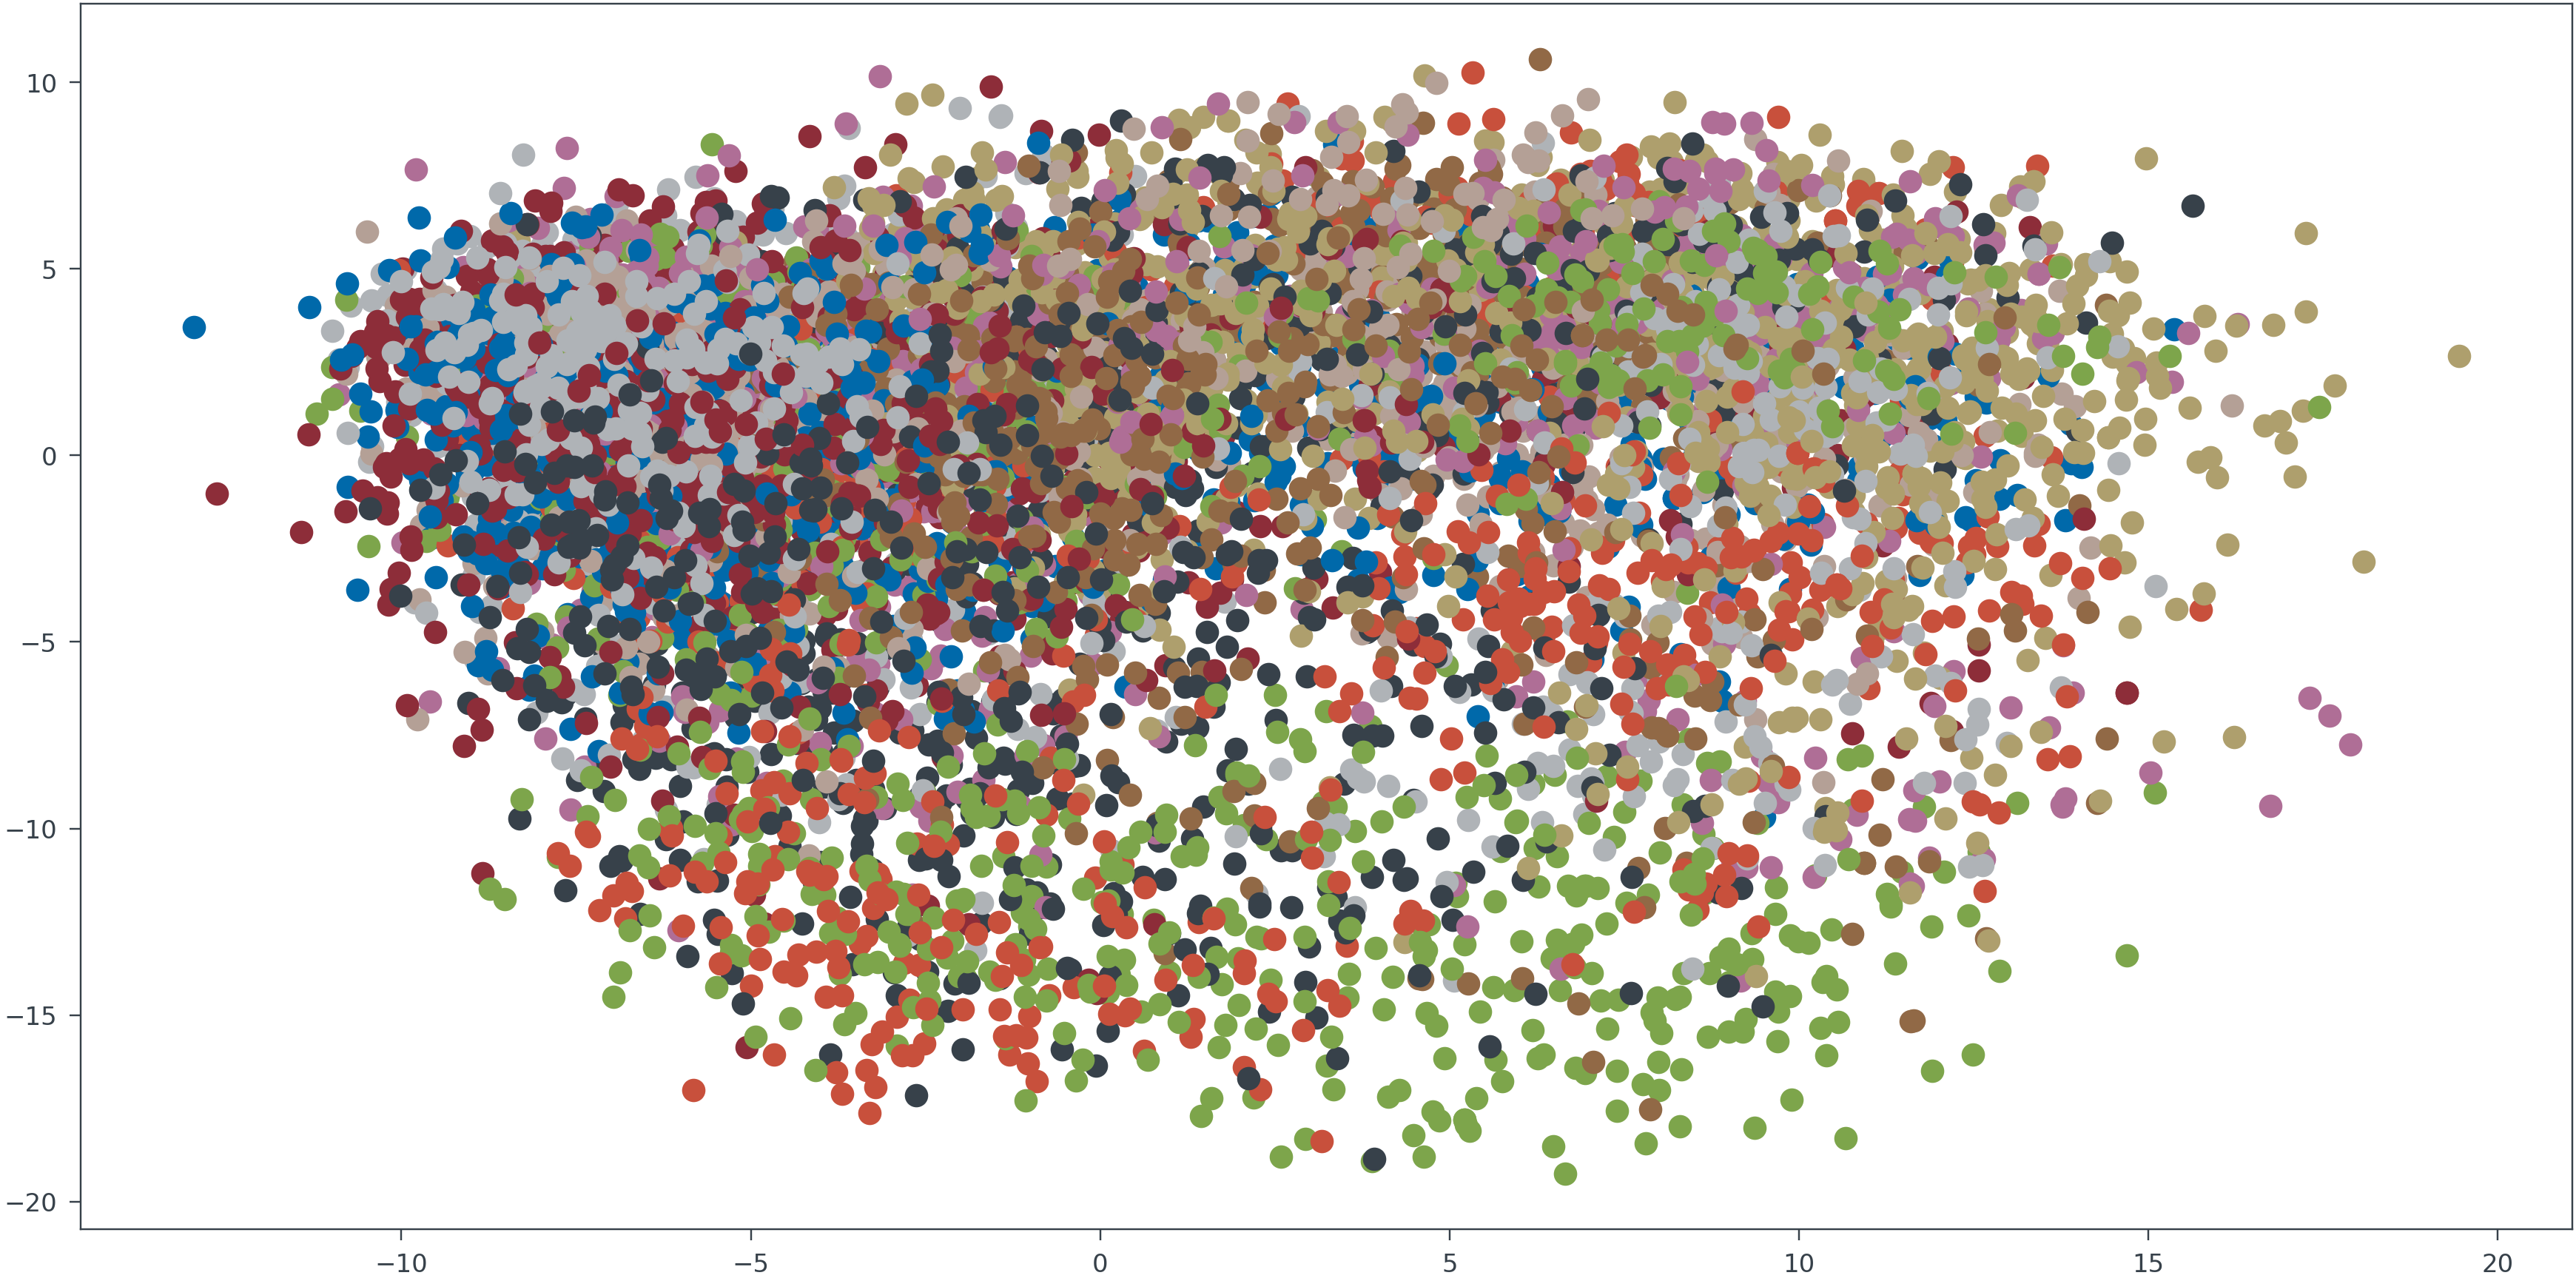

In [42]:
reduced = pls.transform(X)

fig, ax = plt.subplots(figsize=(10, 5))

for cluster_id in range(72):
    mask = predicted_clusters == cluster_id
    ax.scatter(reduced[mask, 0], reduced[mask, 1])

In [43]:
axis_labels_0 = closest_words_for_pc(0, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
axis_labels_1  = closest_words_for_pc(1, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

In [44]:
display_axis_semantics([axis_labels_0, axis_labels_1])

# CHES score 

In [192]:
from src.constants import PATH_MIGRATION_CHES
ches_df = pd.read_parquet(PATH_MIGRATION_CHES)

In [193]:
ches_df.columns[24:]

Index(['party_label_ep', 'party_all_labels_ep', 'party_all_names_ep',
       'party_name_ches', 'party_name_en_ches', 'year_ches', 'country',
       'eastwest', 'eumember', 'party_id', 'party_label_ches', 'cmp_id',
       'vote', 'seat', 'electionyear', 'epvote', 'family', 'govt', 'lrgen',
       'lrecon', 'lrecon_salience', 'lrecon_dissent', 'lrecon_blur', 'galtan',
       'galtan_salience', 'galtan_dissent', 'galtan_blur', 'eu_position',
       'eu_salience', 'eu_dissent', 'eu_blur', 'spendvtax',
       'spendvtax_salience', 'deregulation', 'dereg_salience',
       'redistribution', 'redist_salience', 'econ_interven', 'civlib_laworder',
       'civlib_salience', 'sociallifestyle', 'social_salience',
       'womens_rights', 'lgbtq_rights', 'samesex_marriage',
       'religious_principles', 'relig_salience', 'immigrate_policy',
       'immigrate_salience', 'immigrate_dissent', 'multiculturalism',
       'multicult_salience', 'multicult_dissent', 'nationalism',
       'nationalism_salie

In [194]:
df = ches_df.merge(df, on='Unnamed: 0')

In [195]:
reduced = pls.transform(np.stack(df[EMBEDDING_MODEL]))

In [196]:
ches_scores = ['galtan_salience', 'galtan_dissent', 'galtan_blur', 'eu_position',
       'eu_salience', 'eu_dissent', 'eu_blur', 'spendvtax',
       'spendvtax_salience', 'deregulation', 'dereg_salience',
       'redistribution', 'redist_salience', 'econ_interven', 'civlib_laworder',
       'civlib_salience', 'sociallifestyle', 'social_salience',
       'womens_rights', 'lgbtq_rights', 'samesex_marriage',
       'religious_principles', 'relig_salience', 'immigrate_policy',
       'immigrate_salience', 'immigrate_dissent', 'multiculturalism',
       'multicult_salience', 'multicult_dissent', 'nationalism',
       'nationalism_salience', 'ethnic_minorities', 'ethnic_salience',
       'urban_rural', 'urban_salience', 'environment', 'enviro_salience',
       'climate_change', 'climate_change_salience', 'protectionism', 'regions',
       'region_salience', 'international_security', 'international_salience',
       'us', 'us_salience', 'eu_benefit', 'eu_ep', 'eu_fiscal', 'eu_intmark',
       'eu_employ', 'eu_budgets', 'eu_agri', 'eu_cohesion', 'eu_environ',
       'eu_asylum', 'eu_foreign', 'eu_turkey', 'eu_russia',
       'russian_interference', 'anti_islam_rhetoric', 'people_vs_elite',
       'antielite_salience', 'corrupt_salience', 'members_vs_leadership',
       'executive_power', 'judicial_independence', 'mip_one', 'mip_two',
       'mip_three']

In [197]:
num_tests = len(ches_scores) * 2  # for each axis
alpha = .05
corrected_alpha = alpha / num_tests
corrected_alpha

0.00035714285714285714

In [198]:
import scipy.stats as stats

results = []

for axis in range(2):
    for ches_score in ches_scores:
        non_none_mask = ~df[ches_score].isna()
        if non_none_mask.sum() / len(non_none_mask) > .5:
            corr, p_value = stats.pearsonr(reduced[non_none_mask, axis], df[non_none_mask][ches_score])
            if corrected_alpha >= p_value:
                results.append({"axis": axis, "ches_metric": ches_score, "correlation": corr})
                print(f"Axis - {axis}, Score- {ches_score}", corr, p_value)


Axis - 0, Score- galtan_salience 0.2794995587023507 6.446421142236713e-155
Axis - 0, Score- eu_position -0.6028835905493313 0.0
Axis - 0, Score- eu_salience 0.16431197759672642 1.540530983935958e-53
Axis - 0, Score- eu_dissent -0.1475727569044863 3.03034088929075e-43
Axis - 0, Score- spendvtax 0.07889683346437108 1.9581367837698578e-13
Axis - 0, Score- deregulation -0.09679981824757532 1.764912884715053e-19
Axis - 0, Score- redistribution 0.056032617200280674 1.817560319841324e-07
Axis - 0, Score- civlib_laworder 0.3726346257755459 2.5171351224601444e-283
Axis - 0, Score- sociallifestyle 0.3279540375788399 4.108579021373266e-214
Axis - 0, Score- immigrate_policy 0.3998325244275849 0.0
Axis - 0, Score- multiculturalism 0.3783013968664767 1.1235267697985462e-292
Axis - 0, Score- nationalism 0.4248682765554785 0.0
Axis - 0, Score- ethnic_minorities 0.43845650681441733 0.0
Axis - 0, Score- urban_rural 0.2514679503174218 5.965926225814794e-125
Axis - 0, Score- environment 0.2454864474460778

In [199]:
ches_res = pd.DataFrame(results)
ches_res["corr_magnitude"] = np.abs(ches_res['correlation'])
ches_res.sort_values(by=["axis", "corr_magnitude"])

axis             ches_metric  correlation  corr_magnitude
6      0          redistribution     0.056033        0.056033
4      0               spendvtax     0.078897        0.078897
27     0                 mip_two    -0.095677        0.095677
5      0            deregulation    -0.096800        0.096800
15     0                 regions     0.130868        0.130868
3      0              eu_dissent    -0.147573        0.147573
2      0             eu_salience     0.164312        0.164312
26     0                 mip_one    -0.172482        0.172482
25     0        corrupt_salience     0.208352        0.208352
14     0             environment     0.245486        0.245486
13     0             urban_rural     0.251468        0.251468
0      0         galtan_salience     0.279500        0.279500
16     0  international_security     0.325134        0.325134
8      0         sociallifestyle     0.327954        0.327954
28     0               mip_three    -0.338586        0.338586
7      0         civlib_laworder     0.372635        0.372635
10     0        multiculturalism     0.378301        0.378301
9      0        immigrate_policy     0.399833        0.399833
11     0             nationalism     0.424868        0.424868
12     0       ethnic_minorities     0.438457        0.438457
23     0               eu_turkey    -0.522756        0.522756
20     0              eu_budgets    -0.552702        0.552702
24     0      antielite_salience     0.553891        0.553891
18     0                   eu_ep    -0.554136        0.554136
21     0             eu_cohesion    -0.556802        0.556802
22     0              eu_foreign    -0.584535        0.584535
19     0              eu_intmark    -0.592006        0.592006
1      0             eu_position    -0.602884        0.602884
17     0              eu_benefit     0.607628        0.607628
45     1              eu_intmark     0.042635        0.042635
49     1                 mip_one     0.057115        0.057115
46     1              eu_foreign     0.062807        0.062807
50     1                 mip_two    -0.066287        0.066287
44     1                   eu_ep    -0.086471        0.086471
48     1        corrupt_salience     0.088996        0.088996
47     1               eu_turkey    -0.091068        0.091068
43     1  international_security    -0.167158        0.167158
32     1           econ_interven     0.180239        0.180239
42     1                 regions     0.185586        0.185586
38     1             nationalism     0.202377        0.202377
40     1             urban_rural     0.207952        0.207952
39     1       ethnic_minorities     0.210013        0.210013
30     1            deregulation     0.218079        0.218079
37     1        multiculturalism     0.219904        0.219904
36     1        immigrate_policy     0.226925        0.226925
33     1         civlib_laworder     0.235997        0.235997
29     1               spendvtax     0.255518        0.255518
35     1    religious_principles     0.259858        0.259858
31     1          redistribution     0.269889        0.269889
41     1             environment     0.283712        0.283712
34     1         sociallifestyle     0.284016        0.284016

In [200]:
# environment + strongly supports economic growth even at the cost of environmental protection

# redistribution + Strongly opposes redistribution of wealth

# religious_principles + strongly supports religious principles in politics

# spendvtax + strongly favors reducing taxes

# civlib_laworder + strongly favors tough measures to fight crime

# deregulation + strongly favors deregulation of markets

# immigrate_policy + favors restrictive policy


"""  
10	0	multiculturalism	0.378153	0.378153  + favors assimilation
9	0	immigrate_policy	0.399827	0.399827 + favors restrictive policy
11	0	nationalism	0.424934	0.424934  + promots nationalist conceptions
12	0	ethnic_minorities	0.439418	0.439418  + oppose more rights for ethnic minorities
23	0	eu_turkey	-0.523548	0.523548
20	0	eu_budgets	-0.552113	0.552113 - oppose position of the party leadership on EU authority over member states’ economic
and budgetary policies
24	0	antielite_salience	0.553664	0.553664  + alience of anti-establishment and anti-elite rhetoric importent
18	0	eu_ep	-0.553831	0.553831
21	0	eu_cohesion	-0.556214	0.556214
22	0	eu_foreign	-0.582342	0.582342 - oppose EU authority over FOREIGN and SECURITY POLICY 
19	0	eu_intmark	-0.592217	0.592217 - oppose The INTERNAL MARKET (i.e. free movement of goods, services, capital and labor) 
1	0	eu_position	-0.602549	0.602549 - oppose eu integration
17	0	eu_benefit	0.607315	


"""

'  \n10\t0\tmulticulturalism\t0.378153\t0.378153  + favors assimilation\n9\t0\timmigrate_policy\t0.399827\t0.399827 + favors restrictive policy\n11\t0\tnationalism\t0.424934\t0.424934  + promots nationalist conceptions\n12\t0\tethnic_minorities\t0.439418\t0.439418  + oppose more rights for ethnic minorities\n23\t0\teu_turkey\t-0.523548\t0.523548\n20\t0\teu_budgets\t-0.552113\t0.552113 - oppose position of the party leadership on EU authority over member states’ economic\nand budgetary policies\n24\t0\tantielite_salience\t0.553664\t0.553664  + alience of anti-establishment and anti-elite rhetoric importent\n18\t0\teu_ep\t-0.553831\t0.553831\n21\t0\teu_cohesion\t-0.556214\t0.556214\n22\t0\teu_foreign\t-0.582342\t0.582342 - oppose EU authority over FOREIGN and SECURITY POLICY \n19\t0\teu_intmark\t-0.592217\t0.592217 - oppose The INTERNAL MARKET (i.e. free movement of goods, services, capital and labor) \n1\t0\teu_position\t-0.602549\t0.602549 - oppose eu integration\n17\t0\teu_benefit\t0.

In [205]:
axis_1_ches = ["environment", "redistribution", "religious_principles", "spendvtax", "civlib_laworder"]
axis_0_ches = ["eu_position", "eu_intmark", "eu_cohesion", "antielite_salience", "ethnic_minorities"]

In [206]:
import seaborn as sns


df['reduced_x'] = reduced[:, 0]
df['reduced_y'] = reduced[:, 1]

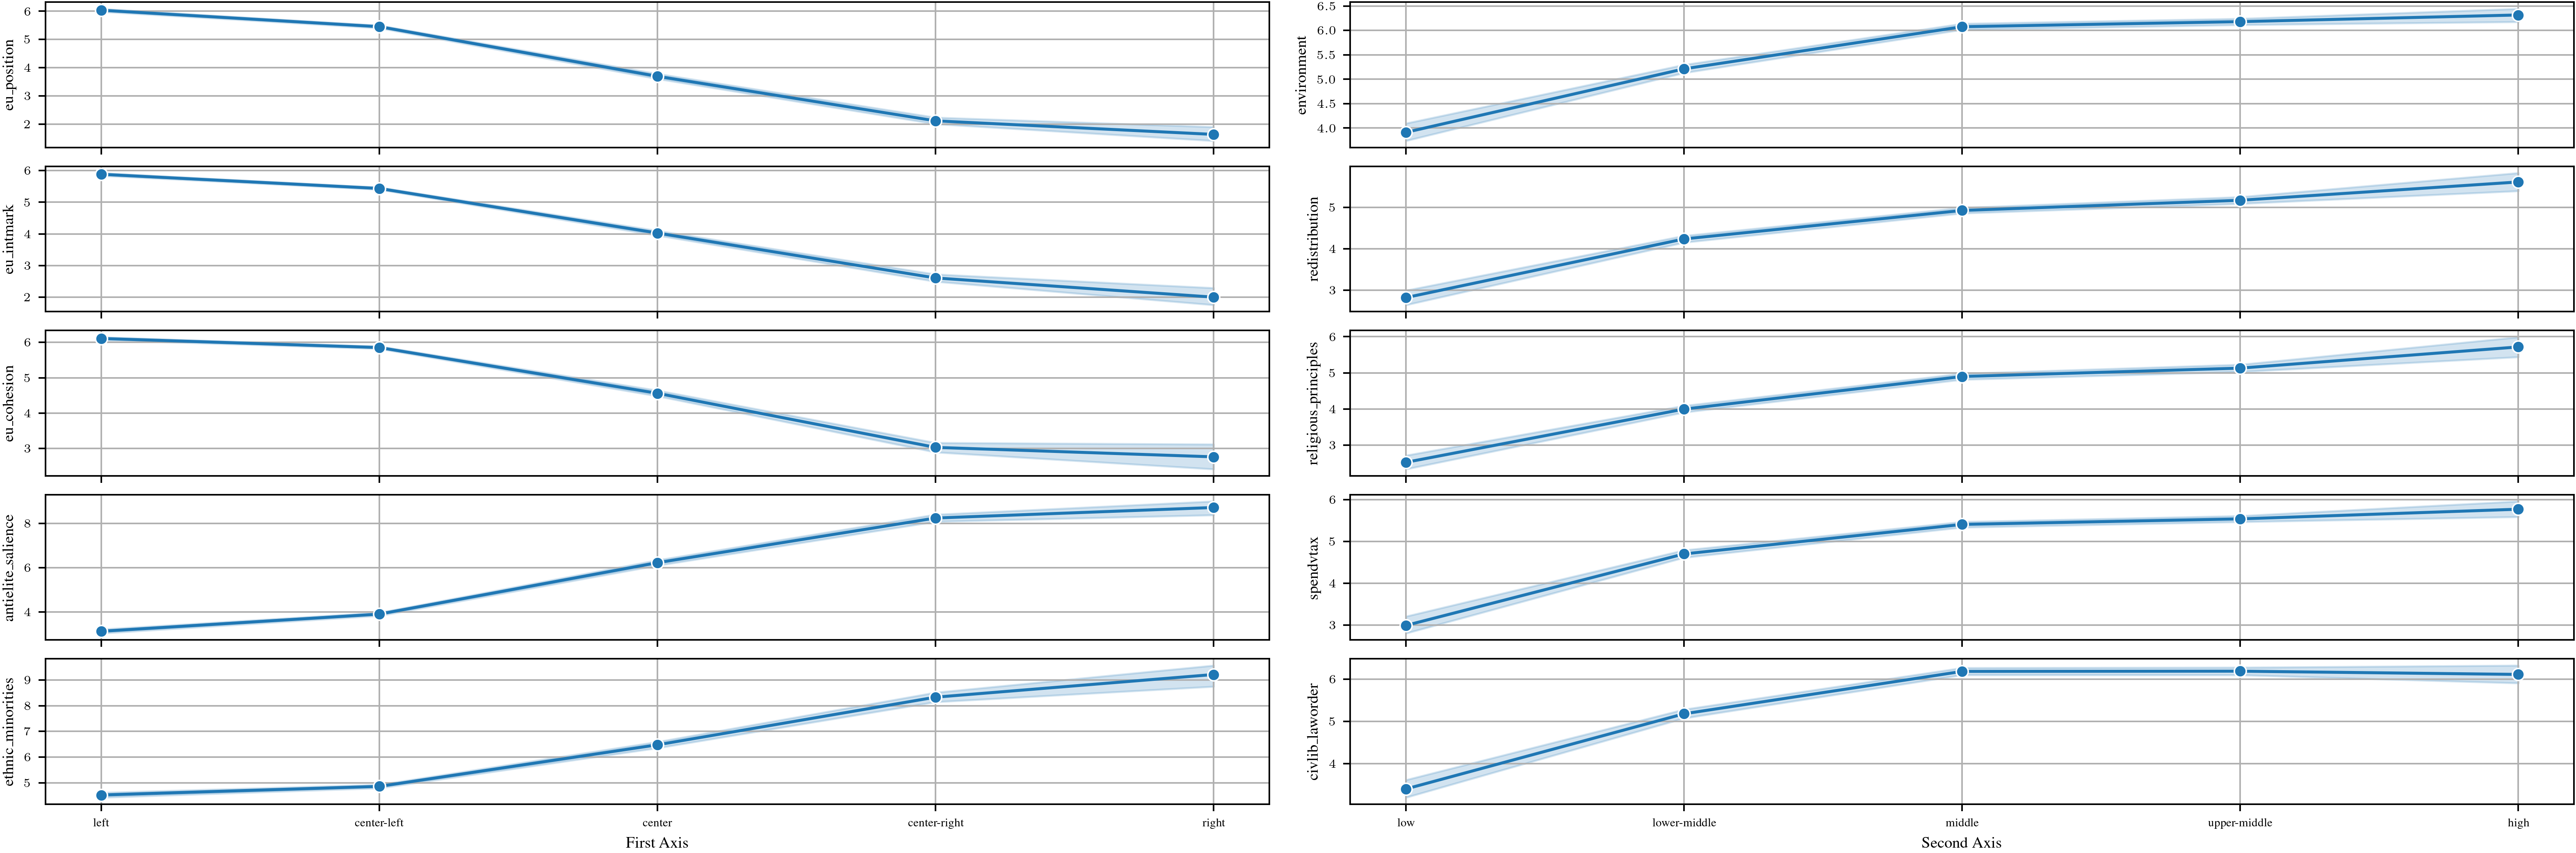

In [207]:
df[f"reduced_bin_y"] = pd.cut(df["reduced_y"], bins=5, labels=["low", "lower-middle", "middle", "upper-middle", "high"])
df[f"reduced_bin_x"] = pd.cut(df["reduced_x"], bins=5, labels=['left', 'center-left', 'center', 'center-right', 'right'])

fig, axs = plt.subplots(5, 2, figsize=(18, 6), sharex='col')

axs[-1][0].set_xlabel("First Axis")
axs[-1][1].set_xlabel("Second Axis")

for idx, (ches_metric_0, ches_metric_1) in enumerate(zip(axis_0_ches, axis_1_ches)):
    sns.lineplot(data=df, x='reduced_bin_x', y=ches_metric_0,  marker='o', ax=axs[idx][0])
    sns.lineplot(data=df, x='reduced_bin_y', y=ches_metric_1,  marker='o', ax=axs[idx][1])
    axs[idx][0].grid()
    axs[idx][1].grid()



In [96]:
df[f"environment_cat"]

0        (7.52, 9.308]
1        (5.732, 7.52]
2        (5.732, 7.52]
3        (5.732, 7.52]
4        (7.52, 9.308]
             ...      
9700    (2.156, 3.944]
9701    (3.944, 5.732]
9702               NaN
9703    (2.156, 3.944]
9704               NaN
Name: environment_cat, Length: 9705, dtype: category
Categories (5, interval[float64, right]): [(0.359, 2.156] < (2.156, 3.944] < (3.944, 5.732] < (5.732, 7.52] < (7.52, 9.308]]

<Axes: xlabel='year_x', ylabel='environment'>

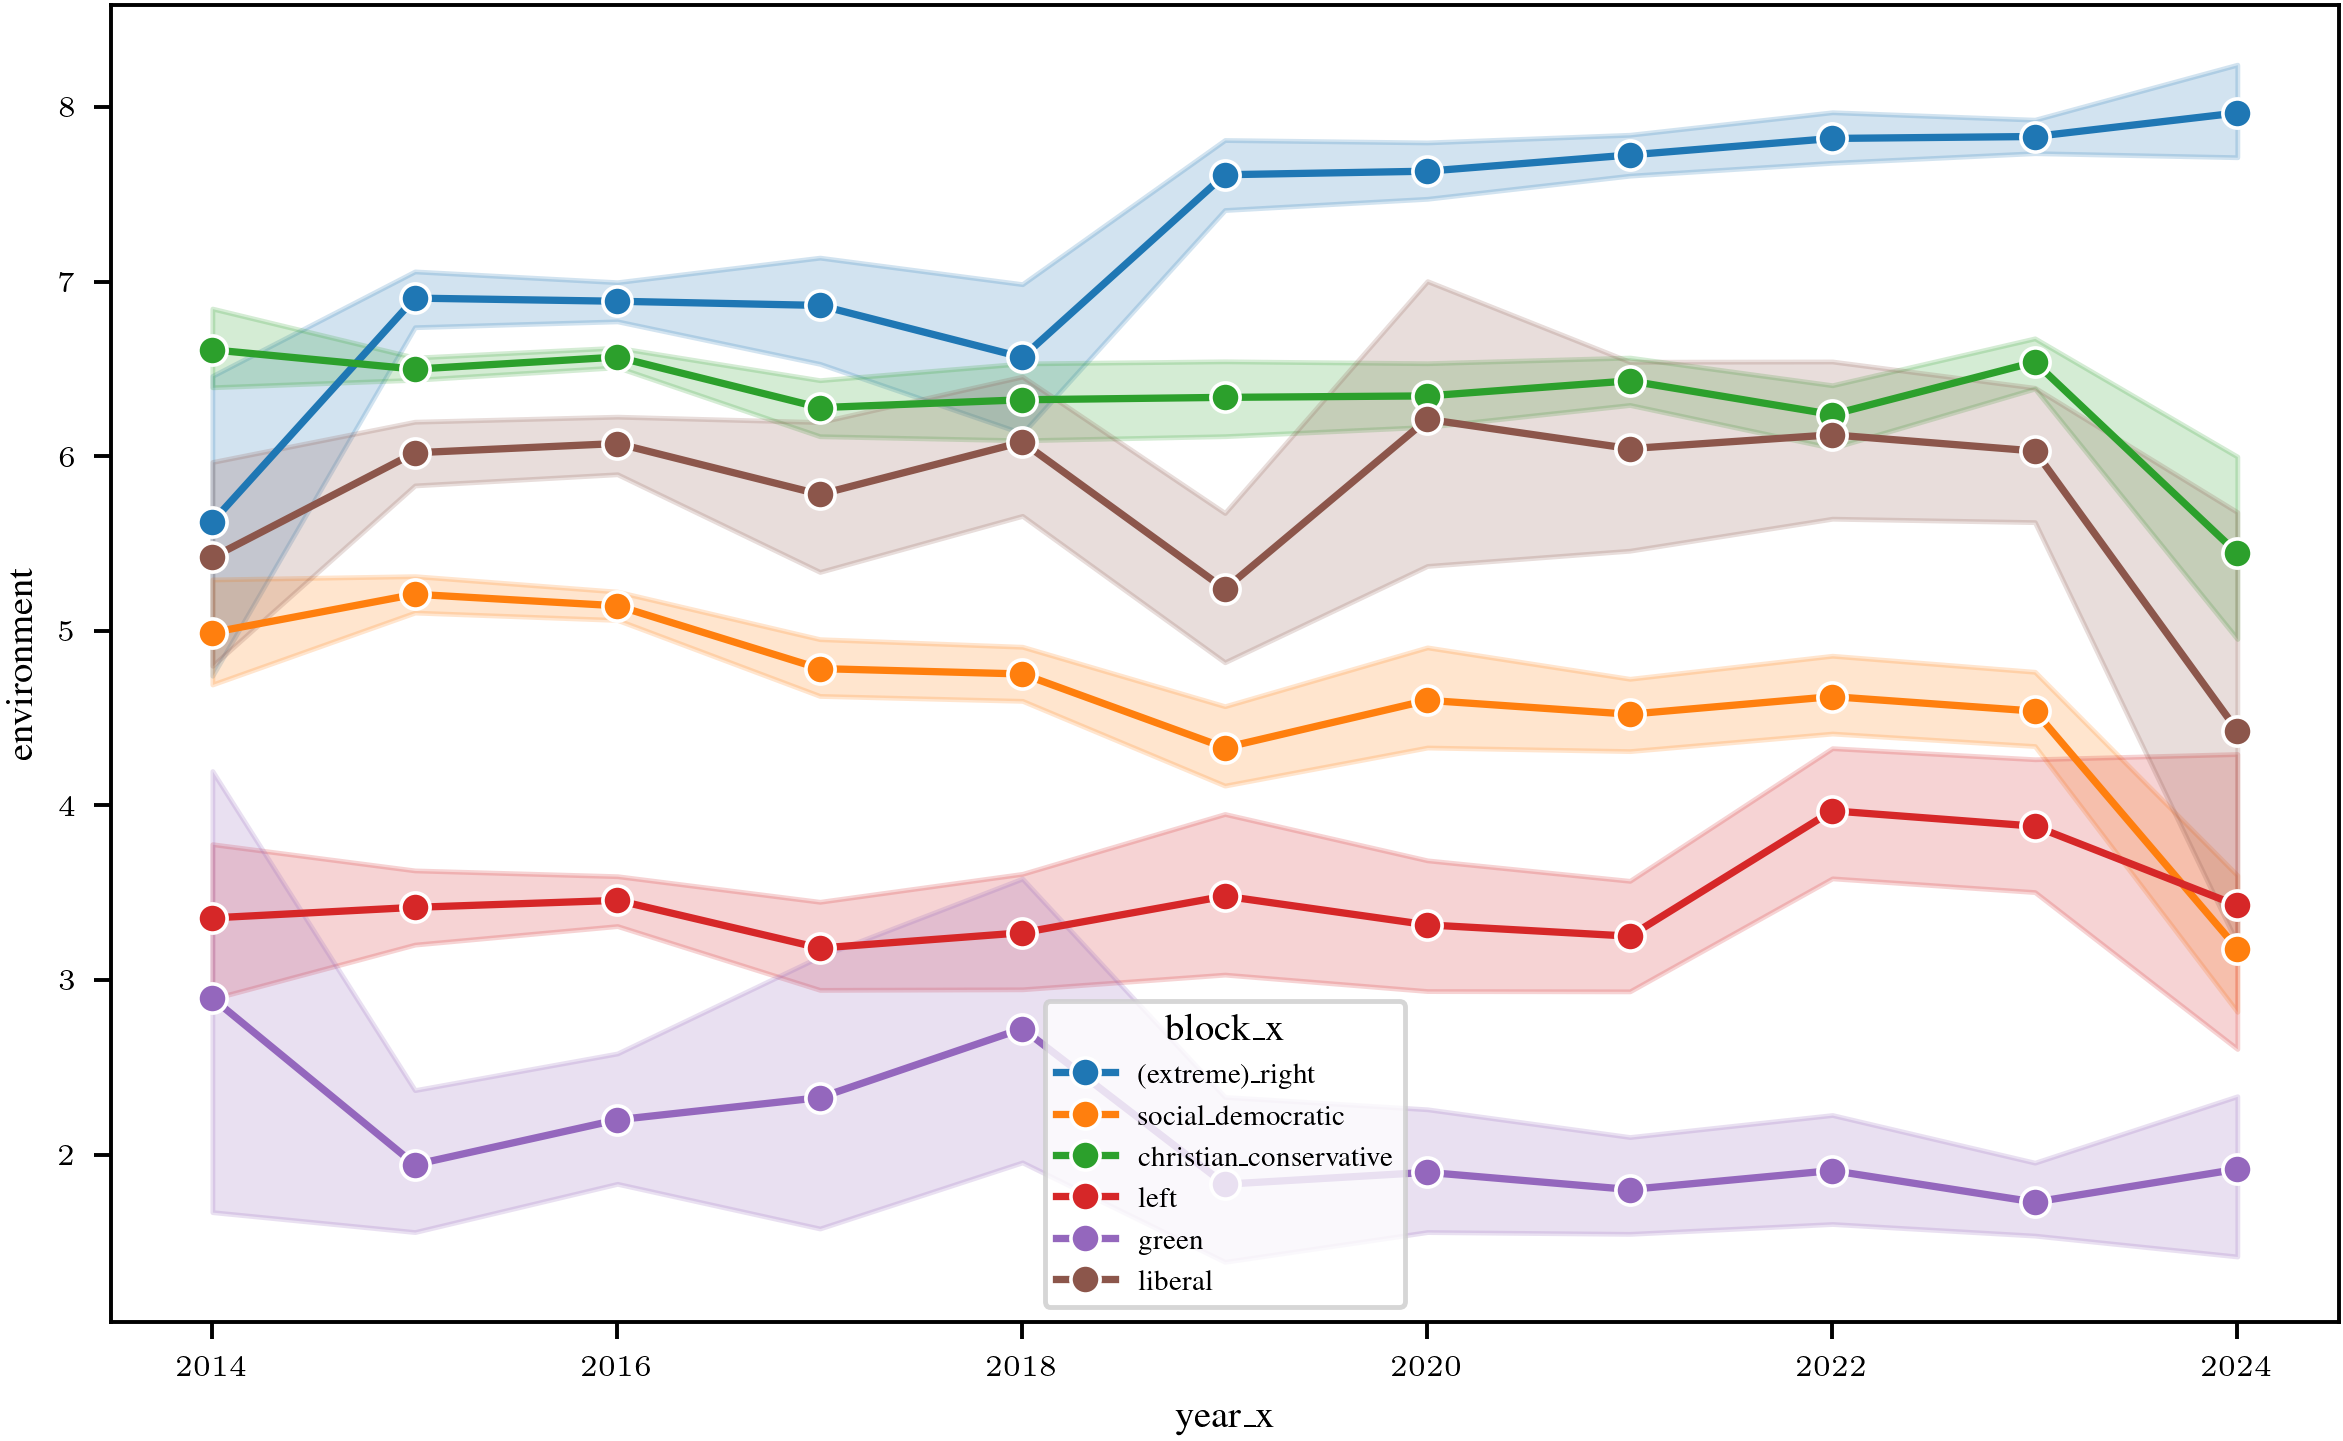

In [92]:
sns.lineplot(data=df, x='year_x', y="environment", hue="block_x", marker='o',)